In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [3]:
train=pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
train.shape

(768, 9)

In [5]:
missing_percentage = train.isnull().mean() * 100
missing_info = missing_percentage[missing_percentage != 0]
print(missing_info)

Series([], dtype: float64)


In [6]:
train.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [7]:
zero_values = (train == 0).sum()

zero_percentages = (zero_values / train.count()) * 100

zero_df = pd.DataFrame({
    'Zero Count': zero_values,
    'Zero Percentage': zero_percentages.round(2)
})

print(zero_df)

                          Zero Count  Zero Percentage
Pregnancies                      111            14.45
Glucose                            5             0.65
BloodPressure                     35             4.56
SkinThickness                    227            29.56
Insulin                          374            48.70
BMI                               11             1.43
DiabetesPedigreeFunction           0             0.00
Age                                0             0.00
Outcome                          500            65.10


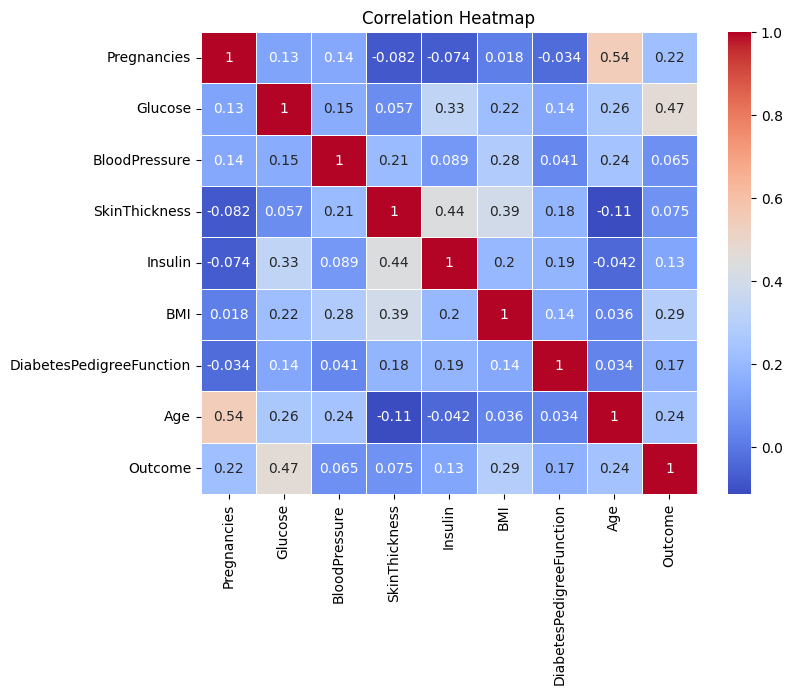

In [8]:
plt.figure(figsize=(8,6))
sn.heatmap(train.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

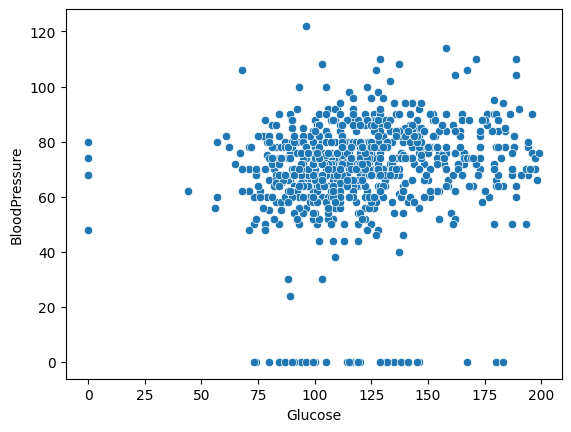

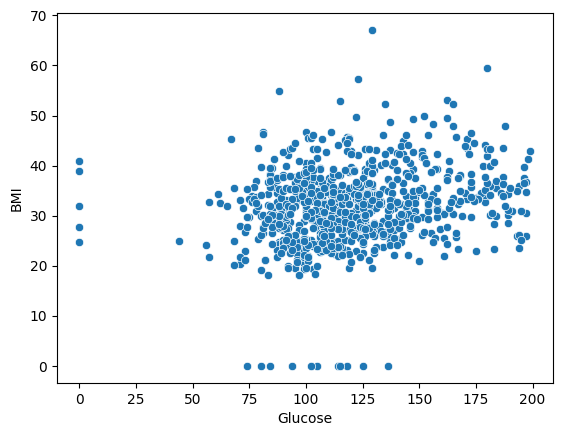

In [9]:
sn.scatterplot(data=train,x='Glucose',y='BloodPressure')
plt.show()
sn.scatterplot(data=train,x='Glucose',y='BMI')
plt.show();

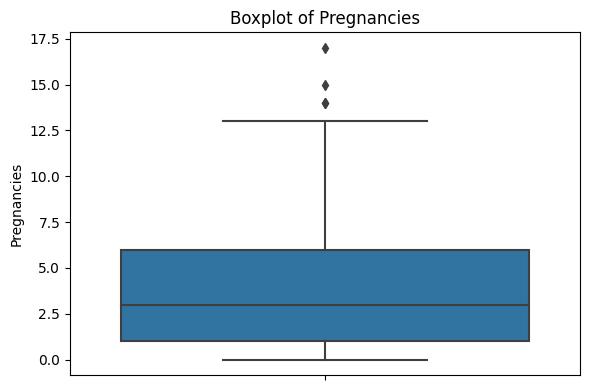

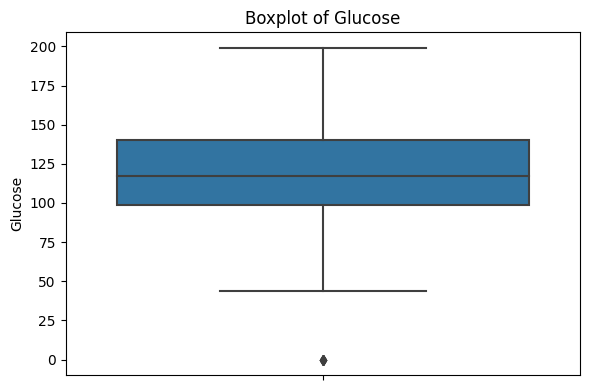

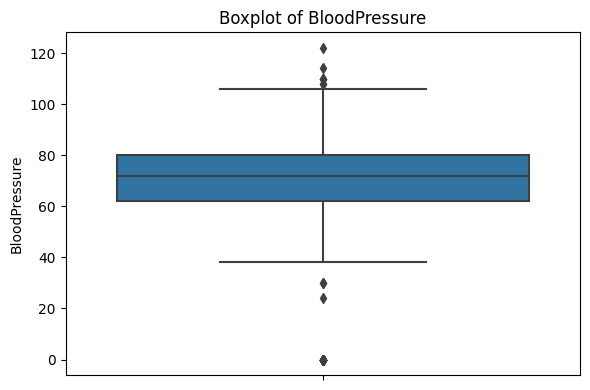

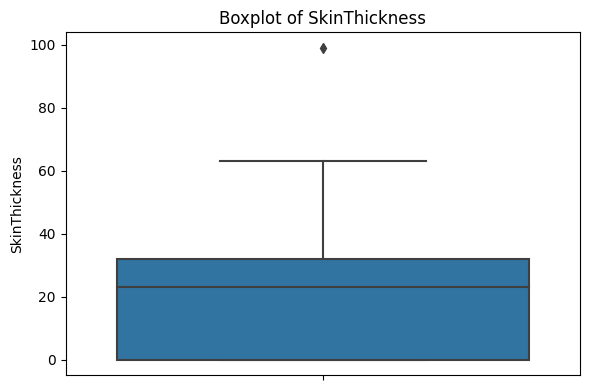

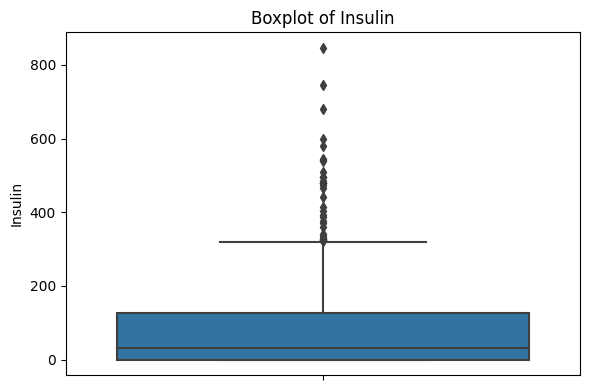

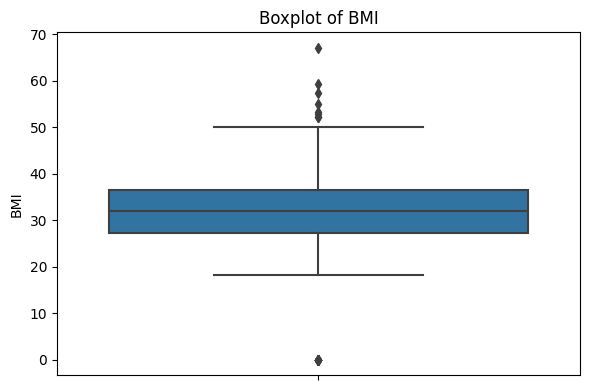

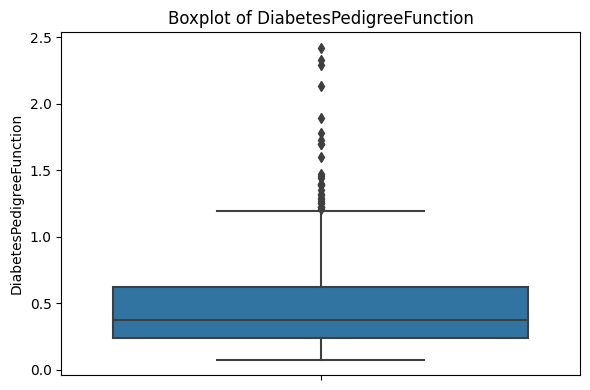

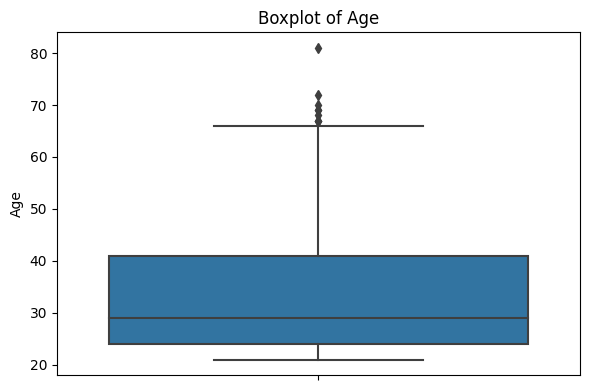

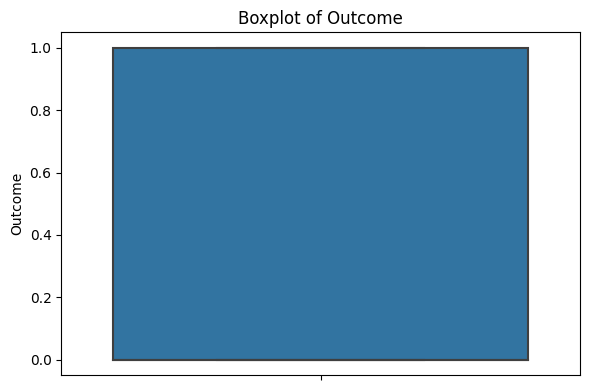

In [10]:
for column in train.columns:
    plt.figure(figsize=(6, 4))
    sn.boxplot(y=train[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

In [11]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
outliers = train[(train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))]
outliers_only = outliers.stack()
print(outliers_only)

4    DiabetesPedigreeFunction      2.288
7    BloodPressure                 0.000
8    Insulin                     543.000
9    BMI                           0.000
12   DiabetesPedigreeFunction      1.441
                                  ...   
706  BMI                           0.000
707  Insulin                     335.000
710  Insulin                     387.000
715  Insulin                     392.000
753  Insulin                     510.000
Length: 146, dtype: float64


<Axes: xlabel='Insulin', ylabel='BloodPressure'>

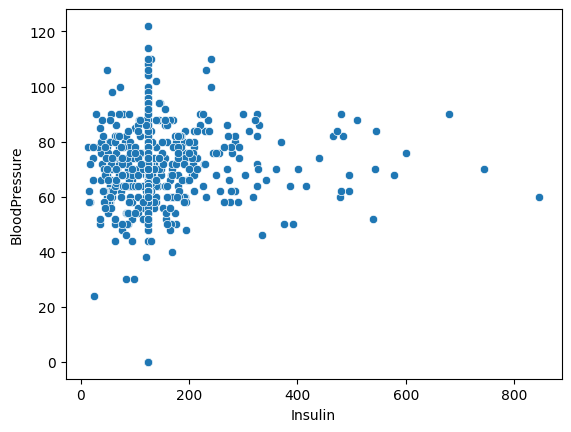

In [12]:
train['Insulin'] = train['Insulin'].replace(0, np.nan)
train['Insulin'] = train['Insulin'].fillna(train['Insulin'].median())
train['Insulin']
sn.scatterplot(data=train,x='Insulin',y='BloodPressure')

In [13]:
def remove_outliers_iqr(train, cols):
    for col in cols:
        Q1 = train[col].quantile(0.25)
        Q3 = train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        train = train[(train[col] >= lower) & (train[col] <= upper)]
    return train

trainclean = remove_outliers_iqr(train, ['Glucose', 'Insulin', 'BMI'])


In [14]:
trainclean.shape

(410, 9)

In [15]:
train.shape

(768, 9)

In [16]:
X = trainclean.iloc[:, :-1]  
y = trainclean.iloc[:, -1]  

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_col = X.select_dtypes(include=['float64', 'int64']).columns
X[numerical_col] = scaler.fit_transform(X[numerical_col])

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 0.01, 0.1],
            'kernel': ['linear', 'rbf']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    }
}
results = []

for model_name, mp in models.items():
    print(f"\n🔍 Tuning {model_name}...")
    grid = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print("Best Params:", grid.best_params_)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': model_name,
        'Best Params': grid.best_params_,
        'Cross-Val Score': grid.best_score_,
        'Test Accuracy': accuracy_score(y_test, y_pred)
    })
import pandas as pd

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Test Accuracy', ascending=False)
print("\n🔎 Model Comparison:")
print(results_df)



🔍 Tuning LogisticRegression...
Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.7926829268292683
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        60
           1       0.63      0.55      0.59        22

    accuracy                           0.79        82
   macro avg       0.74      0.71      0.72        82
weighted avg       0.79      0.79      0.79        82


🔍 Tuning RandomForest...
Best Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Test Accuracy: 0.7439024390243902
              precision    recall  f1-score   support

           0       0.82      0.83      0.83        60
           1       0.52      0.50      0.51        22

    accuracy                           0.74        82
   macro avg       0.67      0.67      0.67        82
weighted avg       0.74      0.74      0.74        82


🔍 Tuning SVM...
Best Params: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Test Accura